In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.regression.linear_model as sm
import statsmodels.api as sm2

# Load SST Data

The [HadISST](https://www.metoffice.gov.uk/hadobs/hadisst/) dataset provides a record of the monthly sea surface temperatures (SSTs) around the globe from 1870-2024.

In [2]:
# load in the HadISST data
dat = Dataset('data/HadISST_sst.nc')
time = dat.variables['time'][:] # every month from 1870 to 2022
lat = dat.variables['latitude'][:] # (90, -90)
lon = dat.variables['longitude'][:] # (-180, 180)
sst = dat.variables['sst'][:,:,:] # sst recorded for each month and co-ordinate

print(lat.shape) # 180 latitudes (89.5, -89.5)
print(lon.shape) # 360 longitudes (-179.5, 179.5)

la = lat.shape[0]
lo = lon.shape[0]
n = la * lo # total number of co-ords 
print(n)

(180,)
(360,)
64800


# Preprocessing SST Data

The annual mean for each SST is calculated in two different ways:

- ssty: Mean annual SST for the months from October to May for each co-ordinate from 1870-2022 
- sstay: Mean annual SST for each co-ordinate starting from 1870-2022

Next the icy regions (mean overall sst <= 0) are removed from the mean SSTs. Finally weights are calculated for each SST to account for the curvature of the Earth:

$$ w_i = \frac{cos(lat_i)}{\Sigma_iw_i} $$

In [3]:
# Calculate sst and ssty -----------------------------------------------------------------------------------

ny = int(sst.shape[0] / 12) # number of years

tidx0 = np.array([10, 11, 12, 13, 14, 15, 16], dtype = 'int')  # months from October-May
ssty = np.zeros((ny, la, lo)) # annual mean SSTs from October-May
sstay = np.zeros((ny, la, lo)) # annual mean SSTs
for i in range(ny):
    tidx = np.array([10, 11, 12, 13, 14, 15, 16]) + i * 12 
    tidx = np.array(tidx, dtype = 'int') 
    ssty[i] = np.nanmean(sst[tidx], axis = 0)
    sstay[i] = np.nanmean(sst[i * 12 : (i + 1) * 12], axis = 0)
    
time = np.arange(1870, 1870 + ny) 

# remove icy regions
mssty = np.mean(ssty, axis = 0) # overall mean ssty for each co-ord
ssty[:, mssty <= 0] = np.nan # replace anywhere that is ice with nan

msstay = np.mean(sstay, axis = 0) # overall mean sstay for each co-ord
sstay[:, msstay <= 0] = np.nan # replace anywhere that is ice with nan

# apply weights
weights = np.cos(np.radians(lat))
weights = weights / np.sum(weights)
weights = np.tile(weights, (lon.shape[0], 1)).T
sstay = sstay * weights
ssty = ssty * weights

# Define Regions 

  The indices for each of the following regions are calculated using the function below.

In [4]:
# returns the indices of the global co-ordinate system that overlaps with a specified rectangular region
def coordinate_indices_from_ra(lat, lon, lat_max, lat_min, lon_max, lon_min):
    la = len(lat) # latitude
    lo = len(lon) # longitude
    n = la * lo
    indices = np.arange(n).reshape((la, lo)) 
    # find the closest overlaping values 
    lat_max = lat[np.argmin(np.abs(lat - lat_max))]
    lat_min = lat[np.argmin(np.abs(lat - lat_min))]
    lon_max = lon[np.argmin(np.abs(lon - lon_max))]
    lon_min = lon[np.argmin(np.abs(lon - lon_min))]
    # get the indices corrsponding to the rectangular region
    ra_indices = indices[np.where(lat == lat_max)[0][0] : np.where(lat == lat_min)[0][0] + 1 , np.where(lon == lon_min)[0][0] : np.where(lon == lon_max)[0][0] + 1 ]
    return np.unique(ra_indices.flatten())

## AMO

$(0 - 80^\circ N), (80^\circ W - 20^\circ E)$ region used to remove multidecadal oscillations trend

## GL

$(60^\circ S - 60^\circ N)$ global region

## NH

$(0^\circ S - 80^\circ N)$ nothern hemisphere region

## DIPOLE

$(45 - 80^\circ N), (70^\circ W - 30^\circ E)$ North Alantic box
$(0 - 45^\circ S), (70^\circ W - 30^\circ E)$ Equatorial Atlantic box

In [5]:
amosidx = coordinate_indices_from_ra(lat, lon, 80, 0, 20, -80)
gloidx = coordinate_indices_from_ra(lat, lon, 60, -60, 179.5, -179.5)
nhidx = coordinate_indices_from_ra(lat, lon, 80, 0, 179.5, -179.5) 
dipole1 = coordinate_indices_from_ra(lat, lon, 80, 45, 30, -70) # higher box
dipole2 = coordinate_indices_from_ra(lat, lon, 0, -45, 30, -70) # lower box

## Subpolar-Gyre Region

The following code finds the indices of the global co-ordinate system that overlaps with the subpolar-gyre region. The co-ordinates of the subpolar gyre region are given in the file [area_ceaser.txt](https://www.pik-potsdam.de/%7ecaesar/AMOC_slowdown/).

In [6]:
area_ceaser_coords = np.loadtxt("area_ceaser.txt") # co-ords of sub-polar gyre region
area_ceaser_coords.shape # latitude and longitude pairs

(744, 2)

In [7]:
# find the indices of the global co-ordinate system that overlap with area_coords
def trmm_indices_for_area(area_coords, trmm_lat, trmm_lon):
    la = len(trmm_lat)
    lo = len(trmm_lon)
    n = la * lo
    indices = np.arange(n).reshape((la, lo)) # give an index to each co-ord
    trmm_coords = np.transpose([np.repeat(trmm_lat, len(trmm_lon)), np.tile(trmm_lon, len(trmm_lat))]) # array of all lat-lon pairings
    lat_max = trmm_lat[np.argmin(np.abs(trmm_lat - np.max(area_coords[:, 0])))] # max latitude in area_coords
    lat_min = trmm_lat[np.argmin(np.abs(trmm_lat - np.min(area_coords[:, 0])))]
    lon_max = trmm_lon[np.argmin(np.abs(trmm_lon - np.max(area_coords[:, 1])))]
    lon_min = trmm_lon[np.argmin(np.abs(trmm_lon - np.min(area_coords[:, 1])))]
    
    # get the indices of all co-ords that overlap with area_coords
    ra_indices = indices[np.where(trmm_lat == lat_max)[0][0] : np.where(trmm_lat == lat_min)[0][0] + 1 , np.where(trmm_lon == lon_min)[0][0] : np.where(trmm_lon == lon_max)[0][0] + 1 ] 
    ra_indices = ra_indices.flatten()
    
    # latitude and longitudes that overlap with area_coords
    trmm_ra_coords = trmm_coords[ra_indices]
    
    # get the indices of the overlap for the full latitude and logitude
    d = np.zeros((len(area_coords), len(ra_indices)))
    for i in range(len(area_coords)):
        for j in range(len(ra_indices)):
            d[i, j] = np.sum(np.abs(area_coords[i] - trmm_ra_coords[j]))
    trmm_indices_area = ra_indices[np.argmin(d, axis = 1)]
    return trmm_indices_area

In [8]:
sgi = trmm_indices_for_area(area_ceaser_coords, lat, lon)

Calculate the linear trend for each SST co-ordinate

In [11]:
sst_trends = np.zeros((lat.shape[0], lon.shape[0]))
for i in range(lat.shape[0]):
    for j in range(lon.shape[0]):
        if mssty[i, j] > 0:
            sst_trends[i, j] = np.polyfit(np.arange(ny), ssty[:, i, j], 1)[0] * 100
        else:
            sst_trends[i, j] = np.nan
sst_trends, lonc = add_cyclic_point(sst_trends, coord=lon)

Plot the regions described above

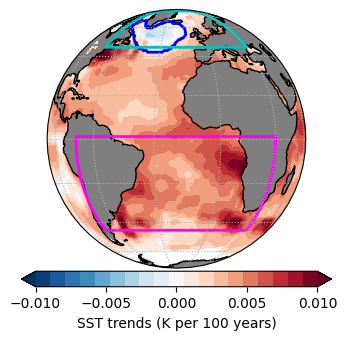

In [15]:
import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point
data_crs = ccrs.PlateCarree()

dipole1_area = np.ones(la * lo)
dipole1_area[dipole1] = -1
dipole1_area = dipole1_area.reshape((lat.shape[0], lon.shape[0]))

dipole2_area = np.ones(la * lo)
dipole2_area[dipole2] = -1
dipole2_area = dipole2_area.reshape((lat.shape[0], lon.shape[0]))

sgi_area = np.ones(la * lo)
sgi_area[sgi] = -1
sgi_area = sgi_area.reshape((lat.shape[0], lon.shape[0]))

amo_area = np.ones(la * lo)
amo_area[amosidx] = -1
amo_area = amo_area.reshape((lat.shape[0], lon.shape[0]))

glo_area = np.ones(la * lo)
glo_area[gloidx] = -1
glo_area = glo_area.reshape((lat.shape[0], lon.shape[0]))

nh_area = np.ones(la * lo)
nh_area[nhidx] = -1
nh_area = nh_area.reshape((lat.shape[0], lon.shape[0]))

fig = plt.figure(figsize = (4, 4))

ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=340))
ax.coastlines()
ax.contour(lon, lat, sgi_area, [0], linestyles = 'solid', linewidths = 2., colors = 'b', transform = data_crs)
ax.contour(lon, lat, dipole1_area, [0], linestyles = 'solid', linewidths = 2., colors = 'c', transform = data_crs)
ax.contour(lon, lat, dipole2_area, [0], linestyles = 'solid', linewidths = 2., colors = 'magenta', transform = data_crs)
#ax.contour(lon, lat, amo_area, [0], linestyles = 'solid', linewidths = 2., colors='lime', transform = data_crs)
cf = ax.contourf(lonc, lat, sst_trends, levels = np.linspace(-.01,.01,20), cmap = plt.cm.RdBu_r, extend = 'both', transform = data_crs)
cbar = plt.colorbar(cf, ax = ax, orientation = 'horizontal', pad = .01, ticks=[-0.01, -0.005, 0, 0.005, 0.01], label="SST trends (K per 100 years)")
gl = ax.gridlines(linestyle=":", draw_labels=False)
#gl.xlocator = mticker.FixedLocator(np.arange(-180,181,30))
#gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
ax.add_feature(cartopy.feature.LAND, color='tab:grey')

In [13]:
fig.savefig("plots/sst_regions_1.png")

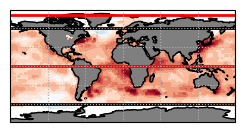

In [14]:
fig = plt.figure()

ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
ax.coastlines()
ax.contour(lon, lat, glo_area, [0], linestyles = 'solid', linewidths = 2., colors='k', transform = data_crs)
ax.contour(lon, lat, nh_area, [0], linestyles = 'solid', linewidths = 2., colors='r', transform = data_crs)
cf = ax.contourf(lonc, lat, sst_trends, levels = np.linspace(-.01,.01,20), cmap = plt.cm.RdBu_r, extend = 'both', transform = data_crs)
#cbar = plt.colorbar(cf, ax = ax, orientation = 'horizontal', pad = .01, ticks=[-0.01, -0.005, 0, 0.005, 0.01], label="SST trends (K per 100 years)")
gl = ax.gridlines(linestyle=":", draw_labels=False)
#gl.xlocator = mticker.FixedLocator(np.arange(-180,181,30))
#gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
ax.add_feature(cartopy.feature.LAND, color='tab:grey')

In [42]:
fig.savefig("plots/sst_regions_2.png")

## $SST_{SG}$

This is the annual mean SST (October to May) for of the subpolar-gyre. 

## $SST_{SG-GM}$

$SST_{SG}$ with global mean SST taken away $SST_{GM}$. 

## $SST_{SG-GM-AMO}$

Here $SST_{AMO}$ is the $SST_{SG-GM}$ index calculated using the annual mean SSTs.

- Fit a linear model between the $SST_{SG-GM}$ and $SST_{AMO}$.
- Subtract the linear model from the $SST_{SG-GM}$

## $SST_{DIPOLE}$

The difference between the annual mean SSTs of the two dipole regions.

$$SST_{DIPOLE} = SST_{DIPOLE_1} - SST_{DIPOLE_2}$$

In [46]:
# SST_SG
amoc1 = np.nansum(ssty.reshape(ssty.shape[0], ssty.shape[1] * ssty.shape[2])[:, sgi], axis = 1) / np.sum(weights.flatten()[sgi])

# SST_SG-GM
gl_mean = np.nansum(ssty.reshape(ssty.shape[0], ssty.shape[1] * ssty.shape[2])[:, gloidx], axis = 1) / np.sum(weights.flatten()[gloidx])
amoc2 = amoc1 - gl_mean

# SST_SG-GM-AMO
gl_mean_ay = np.nansum(sstay.reshape(sstay.shape[0], sstay.shape[1] * sstay.shape[2])[:, gloidx], axis = 1) / np.sum(weights.flatten()[gloidx])
# obtain the mutidecal osscillation trend from the AMO region
amo = np.nansum(sstay.reshape(sstay.shape[0], sstay.shape[1] * sstay.shape[2])[:, amosidx], axis = 1) / np.sum(weights.flatten()[amosidx])  - gl_mean_ay
amo = amo - np.mean(amo[np.where(time == 1901)[0][0] : np.where(time == 1970)[0][0]])
amo = (amo - np.mean(amo))
X = sm2.add_constant(amo)
model = sm2.OLS(amoc2, X)
results = model.fit()
# subtract the AMO trend from SST_SG-GM
amoc3 = amoc2 - results.params[1] * amo - results.params[0]

amoc2 = amoc2 - amoc2.mean()

# SST_DIPOLE
amoc4 = np.nansum(sstay.reshape(sstay.shape[0], sstay.shape[1] * sstay.shape[2])[:, dipole1], axis = 1)  / np.sum(weights.flatten()[dipole1]) \
        - np.nansum(sstay.reshape(sstay.shape[0], sstay.shape[1] * sstay.shape[2])[:, dipole2], axis = 1)  / np.sum(weights.flatten()[dipole2])
amoc4 = amoc4 - amoc4.mean()

# SST_SG-NH
nh_mean = np.nansum(ssty.reshape(ssty.shape[0], ssty.shape[1] * ssty.shape[2])[:, nhidx], axis = 1) / np.sum(weights.flatten()[nhidx])
amoc5 = np.nansum(ssty.reshape(ssty.shape[0], ssty.shape[1] * ssty.shape[2])[:, sgi], axis = 1) / np.sum(weights.flatten()[sgi]) - nh_mean
amoc5 = amoc5 - amoc5.mean()

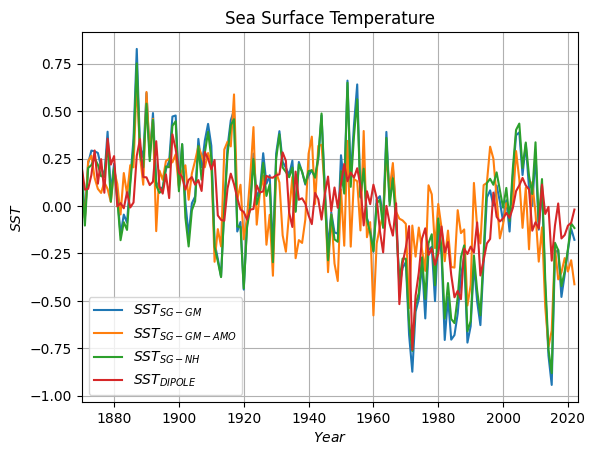

In [15]:
plt.title('Sea Surface Temperature')
plt.xlabel('$Year$')
plt.ylabel('$SST$')
plt.plot(time, amoc2, label='$SST_{SG-GM}$')
plt.plot(time, amoc3, label='$SST_{SG-GM-AMO}$')
plt.plot(time, amoc5, label='$SST_{SG-NH}$')
plt.plot(time, amoc4, label='$SST_{DIPOLE}$')


plt.xlim(1870, 2023)
plt.grid()
plt.legend()

In [15]:
np.savetxt('data/amoc_indices/SST_sg.txt', amoc1)
np.savetxt('data/amoc_indices/SST_sg_gm.txt', amoc2)
np.savetxt('data/amoc_indices/SST_sg_gm_amo.txt', amoc3)
np.savetxt('data/amoc_indices/SST_dipole.txt', amoc4)
np.savetxt('data/amoc_indices/SST_sg_nh.txt', amoc5)